In [1]:
import sys
from pathlib import Path
repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root / "src"))

from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
from dynamic_opt import transition_block_rule, transition_init_block_rule
from schedule_opt import scheduling_milp_block_rule
from tool import solve_mp_milp
import random

## Model configurations

In [2]:
model = ConcreteModel()

# Set the products for this transition.
model.I = Set(initialize=['A', 'B', 'C', 'D', 'E'])      # Products
model.K = Set(initialize=[1, 2, 3, 4, 5])                # Slots

## To fully control the gurobi's parameters, it's better to use gurobi persistent
# mp_solver = SolverFactory('gurobi')

sp_solver = SolverFactory('ipopt')

In [3]:
np.random.seed(40)

# Randomly generated intermediate concentration 
cinit = np.random.uniform(0.8, 1.2)
print("Configuring transition blocks...")
def transition_block_indexed_rule(b, sp, ep):
    if sp == ep:
        return
    else:
        b.start_product = sp
        b.end_product   = ep
        transition_block_rule(b)
model.transitions = Block(model.I, model.I, rule=transition_block_indexed_rule)

print("Configuring initial transition blocks...")
def transition_init_block_indexed_rule(b, ep):
    b.start_product = '*'
    b.end_product = ep
    transition_init_block_rule(b)
    b.cinit.set_value(cinit)
model.transitions_init = Block(model.I, rule=transition_init_block_indexed_rule)

print("Configuring scheduling block...")
def scheduling_block_rule(b):
    b.cinit = Param(initialize=cinit, mutable=True, doc='Initial concentration')
    scheduling_milp_block_rule(b)

scheduling = ConcreteModel(rule=scheduling_block_rule)

Configuring transition blocks...
Configuring initial transition blocks...
Configuring scheduling block...
Adding noise...
In scheduling_opt, calculating transition time bounds...
In scheduling_opt, calculating initial transition time bounds...
Configuring transition cost bounds...
Configuring initial transition cost bounds...


## Solve the model using generalized Benders decomposition
For the hybrid multi-cut implementation, please refer to: 

- [Mitrai, P. Daoutidis, A multicut generalized benders decomposition approach for the integration of process operations and dynamic optimization for continuous systems, Computers & Chemical Engineering 164 (2022) 107859.](https://www.sciencedirect.com/science/article/pii/S0098135422001971)

In [4]:
convergence = False
itr = 0
UB_list = []
LB_list = []
MUB_list = []
gap_list = []
mp_time_list = []
sp_time_list = []
gap = 1.0

while not convergence:
    itr += 1
    print('-'*20 + f'Iteration {itr}' + '-'*20)
    
    MIPGap = 1e-3

    # MIPFocus = random.choice([0, 1, 2])
    best_assign, gap_mp, mp_time, mp_result = solve_mp_milp(scheduling, MIPFocus=1, MIPGap=MIPGap)

    assignment = best_assign
    mp_time_list.append(mp_time)
    
    upper_bound = value(scheduling.obj)
    UB_list.append(upper_bound)

    master_upper_bound = (1+gap_mp) * upper_bound

    # Force the monotone decreasing of upper bound (no need for classic GBD)
    if itr > 1 and master_upper_bound > MUB_list[-1]:
        master_upper_bound = MUB_list[-1]

    MUB_list.append(master_upper_bound)
    print(f'Upper bound = {master_upper_bound:0.2f}')
    
    # Get transition schedule
    trans_pairs = list(assignment.keys())
    print(f'Solution schedule: {trans_pairs[0][0]} -> {trans_pairs[1][0]} -> {trans_pairs[2][0]} -> {trans_pairs[3][0]} -> {trans_pairs[4][0]} -> {trans_pairs[4][1]}')
    
    lower_bound = 0
    sp_time = 0
    for i, ip, k in trans_pairs:
        # 1. fix the transition time
        trans_time_ijk = assignment[i, ip, k]
        print(f'For transition from {i} to {ip} in slot {k}, transition time: {trans_time_ijk:.3f}h')

        if k == 0:
            if hasattr(model.transitions_init[ip], 'trans_time_fix'):
                model.transitions_init[ip].del_component(model.transitions_init[ip].trans_time_fix)
            model.transitions_init[ip].trans_time_fix = Constraint(expr=model.transitions_init[ip].trans_time==trans_time_ijk)
            # 2. solve the subproblem
            result_sp_init = sp_solver.solve(model.transitions_init[ip], tee=False)
            sp_time += result_sp_init.solver.time
            # 3. extract the dual value
            dual_val_init = - model.transitions_init[ip].dual[model.transitions_init[ip].trans_time_fix]
            # 4. add this benders cut to all slots
            phi_init = value(model.transitions_init[ip].obj)
            cut_init_expr = scheduling.eta_init[ip] >= phi_init - dual_val_init * (scheduling.tt_init[ip] - trans_time_ijk)
            scheduling.benders_cuts.add(cut_init_expr)
            print("\tTransition cost:", phi_init)
            # 5. lower bound
            lower_bound += - phi_init

        else:
            if hasattr(model.transitions[i, ip], 'trans_time_fix'):
                model.transitions[i, ip].del_component(model.transitions[i, ip].trans_time_fix)
            model.transitions[i, ip].trans_time_fix = Constraint(expr=model.transitions[i, ip].trans_time==trans_time_ijk)
            # 2. solve the subproblem
            result_sp = sp_solver.solve(model.transitions[i, ip], tee=False)
            sp_time += result_sp.solver.time
            # 3. extract the dual value
            dual_val = - model.transitions[i, ip].dual[model.transitions[i, ip].trans_time_fix]
            # 4. add this benders cut to all slots
            phi_ij = value(model.transitions[i, ip].obj)
            for kk in scheduling.Kt:
                cut_expr = scheduling.eta[i, ip, kk] >= phi_ij - dual_val * (scheduling.tt[i, ip, kk] - trans_time_ijk)
                
                scheduling.benders_cuts.add(cut_expr)
            print(f"\tTransition cost: ${phi_ij:0.2f}")
            # 5. lower bound
            lower_bound += - phi_ij
        
    sp_time_list.append(sp_time)
    
    lower_bound += value(scheduling.obj) + value(scheduling.expr_var_transition_cost) + value(scheduling.expr_var_transition_init_cost)
    if itr > 1 and lower_bound < LB_list[-1]:
        lower_bound = LB_list[-1]

    # Add the lower bound into the master problem
    scheduling.lower_bound = lower_bound

    print(f'Lower bound = {lower_bound:0.2f}')
    LB_list.append(lower_bound)

    # For classic GBD, inexact gap and actual gap coincide.
    gap_inexact = (upper_bound - lower_bound) / abs(lower_bound)
    gap_actual  = (master_upper_bound - lower_bound) / abs(lower_bound)

    gap_list.append(gap_actual)
    print(f'Actual gap: {gap_actual*100:.3f}%')
    print(f'Inexact gap: {gap_inexact*100:.3f}%')

    print('-'*40)

    if itr >= 40:
        print('You suck...')
        break

    # Check the convergence
    if gap_actual <= 1e-3:
        convergence = True
        print('*** Congratulations!!! ***')

print(f"Total master problem runtime: {sum(mp_time_list):0.2f}s")
print(f"Total subproblem runtime: {sum(sp_time_list):0.2f}s")

--------------------Iteration 1--------------------
Set parameter Username
Set parameter LicenseID to value 2589360
Academic license - for non-commercial use only - expires 2025-11-23
        0.00 seconds required for presolve
        0.08 seconds required for solver
        0.00 seconds required for postsolve
Upper bound = 11212711.16
Solution schedule: * -> C -> A -> B -> D -> E
For transition from * to C in slot 0, transition time: 2.507h
	Transition cost: 198893.45699998547
For transition from C to A in slot 1, transition time: 1.641h
	Transition cost: $32670.38
For transition from A to B in slot 2, transition time: 1.930h
	Transition cost: $9609.50
For transition from B to D in slot 3, transition time: 0.308h
	Transition cost: $2439574.26
For transition from D to E in slot 4, transition time: 0.301h
	Transition cost: $932290.86
Lower bound = 7618460.84
Actual gap: 47.178%
Inexact gap: 47.178%
----------------------------------------
--------------------Iteration 2-----------------

In [5]:
print(f"Total profit: ${value(scheduling.obj):0.2f}")
print("Transition costs:")
for i, ip, k in list(trans_pairs):
    if k == 0:
        t_cost = value(model.transitions_init[ip].obj)
    else:
        t_cost = value(model.transitions[i, ip].obj)
    print(f"    {i} -> {ip}: ${t_cost:0.2f}")

Total profit: $10781579.27
Transition costs:
    * -> E: $67789.17
    E -> D: $66356.84
    D -> C: $75162.70
    C -> A: $32670.38
    A -> B: $9609.50


## Convergence plots

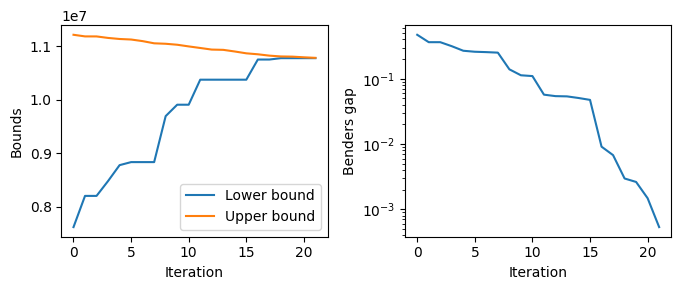

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7,3))
axs[0].plot(LB_list, label='Lower bound')
axs[0].plot(MUB_list, label='Upper bound')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Bounds')
axs[0].legend()

axs[1].plot(gap_list)
axs[1].set_yscale('log')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Benders gap')

plt.tight_layout()

## Visualization of subproblems (dynamic optimizations).

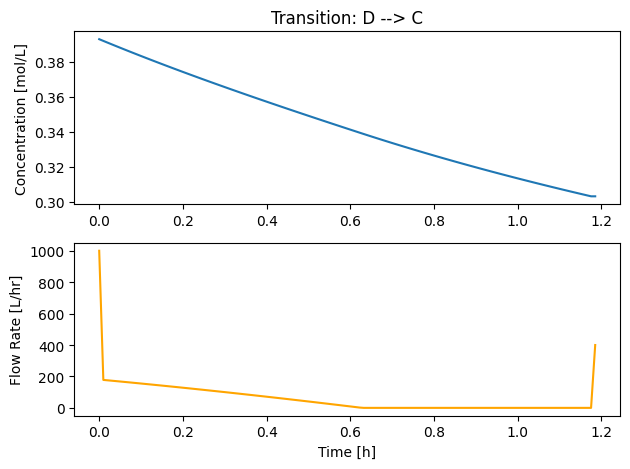

In [7]:
def plot_C_Q(b):
    t_vals = np.array(list(sorted(b.tau))) * b.trans_time.value
    C_vals = [value(b.C[t]) for t in b.tau]
    Q_vals = [value(b.Q[t]) for t in b.tau]
    
    p = plt.figure()
    plt.subplot(2,1,1)
    plt.plot(t_vals, C_vals, label='C')
    plt.title(f"Transition: {b.start_product} --> {b.end_product}")
    plt.ylabel('Concentration [mol/L]')
    plt.subplot(2,1,2)
    plt.plot(t_vals, Q_vals, label='Q', color='orange')
    plt.ylabel('Flow Rate [L/hr]')
    plt.xlabel('Time [h]')
    plt.tight_layout()
    plt.show()

# plot_C_Q(model.transitions_init['E'])
plot_C_Q(model.transitions[('D','C')])


## Production Quantities

In [8]:
scheduling.production_quan.display()

production_quan : Size=25, Index=I*K
    Key      : Lower : Value              : Upper : Fixed : Stale : Domain
    ('A', 1) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('A', 2) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('A', 3) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('A', 4) :     0 :  2733.219624067116 :  None : False :  True : NonNegativeReals
    ('A', 5) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('B', 1) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('B', 2) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('B', 3) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('B', 4) :     0 :                0.0 :  None : False :  True : NonNegativeReals
    ('B', 5) :     0 : 5288.5348774867525 :  None : False :  True : NonNegativeReals
    ('C', 1) :     0 :                